----
# Example using the chi-matrix to simulate noisy circuits
----

As a first example, we apply three known noise channels to an initial pure state. Each channel is applied multiple times sequentially and we compute how the squared overlap changes depending on the number of applications.

When a single channel corresponds to a noisy evolution for a certain fixed duration, the number of channel applications plays the role of time.

We consider the following channels:
* depolarizing
* dephasing
* amplitude damping

At the end of the notebook we include some quick test to confirm the implementation of class `ChiMatrix` and its methods.

----

### Import Intel QS library

We start by importing the Python library with the class and methods defined in the C++ implementation.

In [1]:
# Import the Python library with the C++ class and methods of Intel Quantum Simulator.
# Since the library is not contained in the same folder of this notebook, its path has to be added.
import sys
sys.path.insert(0, '../build/lib')
import intelqs_py as iqs

import numpy as np              # Import NumPy library
import matplotlib.pyplot as plt # Import graphical library for plots
import pandas as pd             # Import library to store results in dataframes
import pickle                   # Import library to save dataframes

# Name of files and directories
data_dir = './noise_via_chi_matrix/'
file_df1 = data_dir + 'study_TYPE-channel_qQUBITS.pkl'
num_qubits = 4                  # number of qubits

## [0] Simulate repetead applications of the same channel

For all channels, the initial state is $|-\rangle_3 |+\rangle_2 |1\rangle_1 |0\rangle_0$, with qubits ordered from right to left.

### Depolarizing channel

The input state $\rho$ is transformed to the output state $\rho^\prime$ according to: 
$$\rho^\prime = (1-p) \rho + \frac{p}{3} ( X.\rho.X + Y.\rho.Y + Z.\rho.Z )$$

Interpretation: nothing happens with probability $(1-p)$, otherwise each of the Pauli errors happens with equal probability $p/3$. Convergence towards the maximally mixed state happens with (single qubit) rate $\lambda=4 \frac{p}{3}$.


### Dephasing channel

The input state $\rho$ is transformed to the output state $\rho^\prime$ according to: 
$$\rho^\prime = (1-p) \rho + p Z.\rho.Z$$

Interpretation: nothing happens with probability $(1-p)$, otherwise the Pauli Z error happens with probability $p$.

### Amplitude-damping channel

The Kraus operators are $M_0=\begin{bmatrix} 1 & 0 \\ 0 & \sqrt{1-p}\end{bmatrix}$
and $M_1=\begin{bmatrix} 0 & \sqrt{p} \\ 0 & 0 \end{bmatrix}$.

The decomposition in Pauli matrices leads to:
$M_0 = \frac{1+\sqrt{1-p}}{2} I + \frac{1-\sqrt{1-p}}{2} Z$ and 
$M_1 = \frac{\sqrt{p}}{2} (X  + i Y)$.

The result is:
$$\rho^\prime = M_0 \rho M_0^\dagger + M_1 \rho M_1^\dagger = \sum_{i,j} \chi_{i,j} \sigma_i \rho \sigma_j$$
with
$$\chi = \frac{1}{4} \begin{bmatrix} (1+\sqrt{1-p})^2 & 0 & 0 & p \\
                                    0 & p^2 & -i p^2 & 0 \\
                                    0 & i p^2 & p^2 & 0 \\
                                    p & 0 & 0 & (1-\sqrt{1-p})^2 \end{bmatrix}$$

In [9]:
assert True and "data already saved in pandas dataframes"

#channel_type = 'depolarizing'
#channel_type = 'dephasing'
channel_type = 'amplitude-damping'

# Prapare the initial state
assert num_qubits == 4                                        # number of qubits
index = 0*1 + 1*2 + 0*4 + 1*8
psi = iqs.QubitRegister(num_qubits, 'base', index, 0) # |psi> = |1010> = |1>_3 .|0>_2 .|1>_1 .|0>_0
psi.ApplyHadamard(2)                                  # |psi> = |1+10>
psi.ApplyHadamard(3)                                  # |psi> = |-+10>

# Associate a random-number-generator to the state
rng = iqs.RandomNumberGenerator();
rng_seed = 7777;
rng.SetSeedStreamPtrs( rng_seed );

# Define the chi-matrix
p=0.01
chi = iqs.CM4x4()
if channel_type == 'depolarizing':
    chi[0,0] = 1-p
    chi[1,1] = p/3
    chi[2,2] = p/3
    chi[3,3] = p/3
elif channel_type == 'dephasing':
    chi[0,0] = 1-p
    chi[3,3] = p
elif channel_type == 'amplitude-damping':
    chi[0,0] = (1+np.sqrt(1-p))**2 /4
    chi[0,3] = p/4
    chi[3,0] = p/4
    chi[3,3] = (1-np.sqrt(1-p))**2 /4
    chi[1,1] = p**2 /4
    chi[1,2] = -1j * p**2 /4
    chi[2,1] = +1j * p**2 /4
    chi[2,2] = p**2 /4
else:
    assert False
chi.SolveEigenSystem()
chi.Print(True)

# parameter of the evolution
num_ensemble_states = 500
num_time_steps = 200
collective_list = []
for s in range(num_ensemble_states):
    if s%100==0:
        print("-- state", s, "of the ensemble")
    psi_s = iqs.QubitRegister(psi)
    psi_s.SetRngPtr(rng);
    for t in range(0,num_time_steps):
        sq_overlap = np.absolute(psi_s.ComputeOverlap(psi))**2 # the overlap is computed as if at the begin of time step t
        if sq_overlap>1:
            print(s, t, sq_overlap)
            psi_s.Print('large overlap?')
        if psi_s.GetOverallSignOfChannels() < 0:
            sq_overlap = sq_overlap * (-1)
            print('possible error: overall negative sign')
        for q in range(num_qubits):
            psi_s.ApplyChannel(q, chi)         # then the channel is implemented
        collective_list.append([s, t, sq_overlap])
df = pd.DataFrame(collective_list, columns =['s', 't', 'sq_overlap'])
filename = file_df1.replace('TYPE', channel_type)
filename = filename.replace('QUBITS', str(num_qubits))
df.to_pickle(filename)
print('data saved in file ', filename)

-- state 0 of the ensemble
-- state 100 of the ensemble
-- state 200 of the ensemble
-- state 300 of the ensemble
-- state 400 of the ensemble
data saved in file  ./noise_via_chi_matrix/example_amplitude-damping-channel_q4.pkl


## [1] Plot the results (one type of channel at a time)

Depolarizing:  
$|0\rangle\langle 0| \rightarrow I$  
$|1\rangle\langle 1| \rightarrow I$

Dephasing:  
$|0\rangle\langle 0| \rightarrow |0\rangle\langle 0|$  
$|1\rangle\langle 1| \rightarrow |1\rangle\langle 1|$

Amplitude-damping:  
$|0\rangle\langle 0| \rightarrow |0\rangle\langle 0|$  
$|1\rangle\langle 1| \rightarrow |0\rangle\langle 0|$

<bound method NDFrame.head of          s    t  sq_overlap
0        0    0    1.000000
1        0    1    0.980309
2        0    2    0.961031
3        0    3    0.942155
4        0    4    0.923673
...    ...  ...         ...
99995  499  195    0.032765
99996  499  196    0.032267
99997  499  197    0.031777
99998  499  198    0.031295
99999  499  199    0.030821

[100000 rows x 3 columns]>


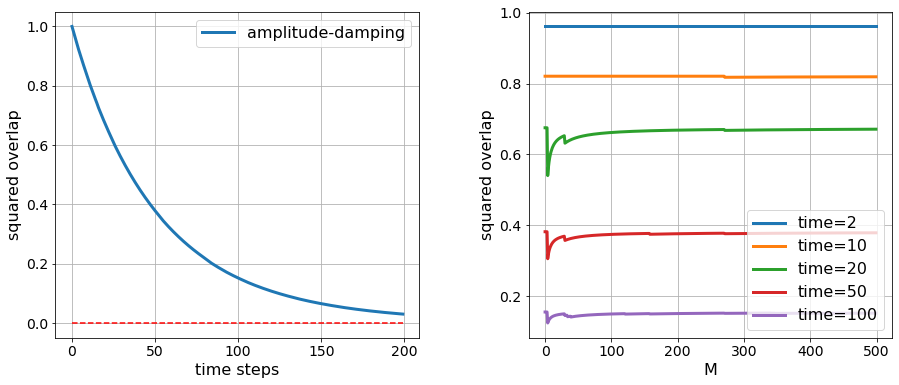

figure saved as file  ./noise_via_chi_matrix/study_amplitude-damping-channel_q4_t200_s500.png


In [10]:
#channel_type = 'depolarizing'
#channel_type = 'dephasing'
channel_type = 'amplitude-damping'

filename = file_df1.replace('TYPE', channel_type)
filename = filename.replace('QUBITS', str(num_qubits))
df = pd.read_pickle(filename)
print(df.head)

fig, axs = plt.subplots(1,2, sharex=False, figsize=(15, 6))
fig.subplots_adjust(wspace=0.3)
axs[0].tick_params(axis='both', labelsize=14)
axs[1].tick_params(axis='both', labelsize=14)

dfs = df.groupby(['t'])['sq_overlap'].mean().reset_index()
axs[0].plot(dfs.t, dfs.sq_overlap, linewidth=3, label=channel_type)
if channel_type == 'depolarizing':
    #axs[0].plot(dfs.t, 1/2+1/2*np.exp(-rate*dfs.t))
    axs[0].plot(dfs.t, [1/2**num_qubits]*len(dfs.t), 'r--')
elif channel_type == 'dephasing':
    #axs[0].plot(dfs.t, 1/4+3/4*np.exp(-p*dfs.t))
    axs[0].plot(dfs.t, [1/2**(num_qubits/2)]*len(dfs.t), 'r--')
elif channel_type == 'amplitude-damping':
    axs[0].plot(dfs.t, [0]*len(dfs.t), 'r--')

# Fix time step, compute the convergence when average is over more ensemble states.
for t in [2, 10, 20, 50, 100]:
    # If we do not take a copy, pandas would complain that:
    # 'A value is trying to be set on a copy of a slice from a DataFrame.'
    dft = df.loc[(df['t'] == t)].copy()
    a = dft['sq_overlap'].to_numpy()
    a = np.cumsum(a)
    b = np.ones(num_ensemble_states)
    b = np.cumsum(b)
    c = np.divide(a, b)
    dft['avg_sq_overlap'] = c
    axs[1].plot(dft.s, dft.avg_sq_overlap, linewidth=3, label='time={}'.format(t))

axs[0].set_ylabel('squared overlap', fontsize=16)
axs[0].set_xlabel('time steps', fontsize=16)
axs[0].grid()
axs[0].legend(loc='upper right', fontsize=16)
axs[1].set_xlabel('num states in the average', fontsize=16)
axs[1].set_xlabel('M', fontsize=16)
axs[1].set_ylabel('squared overlap', fontsize=16)
axs[1].legend(loc='lower right', fontsize=16)
axs[1].grid()

filename = data_dir + 'study_{}-channel_q{}_t{}_s{}.png'.format(
    channel_type, num_qubits, num_time_steps, num_ensemble_states)
fig.savefig(filename)
plt.show()
print('figure saved as file ', filename)

### UTILITY CHECKS

Confirm the correct behavior of ChiMatrix methods by considering the 2x2 symmetric matrix:
$$M = \begin{bmatrix} 1 & 3 \\ 3 & 7 \end{bmatrix}$$

In [80]:
from numpy import linalg as la

M = np.array([[1,3],[3,7]])
print('Original matrix:\n', M, '\n')
w, v = la.eig(M)
print('Eigenvalues:', w)
print('Eigenvectors:', v[:,0], 'and', v[:,1], '\n')

# Eigenvectors need to be 'standardized' so that: M = w0 |v0><v0| + w1 |v1><v1|
v0 = np.array(v[:,0]); v0.shape = (2,1)
v1 = np.array(v[:,1]); v1.shape = (2,1)
assert v0.conj().transpose().dot(v1) == 0
M_current = w[0] * v0.dot(v0.conj().transpose()) + w[1] * v1.dot(v1.conj().transpose())
# Is this currently the case?
print('Before standardization:  M =?=\n', M_current, '\n')

# If not, standardize the eigenvectors.
# (this is done automatically inside class ChiMatrix when method SolveEigensystem is called)
a0 = v0.conj().transpose().dot(M.dot(v0))
s0 = v0 * np.sqrt(abs(w[0]/a0))
a1 = v1.conj().transpose().dot(M.dot(v1))
s1 = v1 * np.sqrt(abs(w[1]/a1))
M_current = w[0] * s0.dot(s0.conj().transpose()) + w[1] * s1.dot(s1.conj().transpose())
np.set_printoptions(linewidth=150)
print('After standardization, eigenvectors:', s0.transpose(), 'and', s1.transpose())
print('After standardization:  M =?=\n', M_current, '\n')

# Normalization of the eigenvectors.
p_norm = abs(w[0]) + abs(w[1])
p0 = abs(w[0]) / p_norm
p1 = abs(w[1]) / p_norm
n0 = s0 * np.sqrt(p_norm)
n1 = s1 * np.sqrt(p_norm)
print('After normalization, eigenvectors:', n0.transpose(), 'and', n1.transpose())

Original matrix:
 [[1 3]
 [3 7]] 

Eigenvalues: [-0.24264069  8.24264069]
Eigenvectors: [-0.92387953  0.38268343] and [-0.38268343 -0.92387953] 

Before standardization:  M =?=
 [[1. 3.]
 [3. 7.]] 

After standardization, eigenvectors: [[-0.92387953  0.38268343]] and [[-0.38268343 -0.92387953]]
After standardization:  M =?=
 [[1. 3.]
 [3. 7.]] 

After normalization, eigenvectors: [[-2.69121547  1.11473795]] and [[-1.11473795 -2.69121547]]


----
## END
----